# Difference-in-Differences (DiD) and Interrupted Time Series Analysis (ITSA) for Causal Inference

## Configurable Causal Inference Analysis Framework

This notebook implements a comprehensive causal inference analysis using both **Difference-in-Differences (DiD)** and **Interrupted Time Series Analysis (ITSA)** methodologies. The notebook is designed to be easily adaptable to different treatment interventions and outcome variables through configurable parameters.

### Key Features:
- **Direct data loading** from existing longitudinal datasets
- **Robust confounder control** using HR attributes and collaboration metrics
- **Progressive control strategies** with multiple DiD specifications
- **Parallel trends assumption testing** for both DiD and ITSA
- **Enhanced ITSA with matched controls** for improved causal identification
- **Comprehensive results comparison** between methodologies

### Analysis Overview:
1. **Data Loading**: Load pre-existing longitudinal data with treatment indicators
2. **Balance Assessment**: Check covariate balance between treatment and control groups  
3. **Assumption Testing**: Validate parallel trends assumption critical for causal identification
4. **DiD Analysis**: Multiple specifications from basic to fully-controlled models
5. **ITSA Analysis**: Time series analysis with autocorrelation and matching
6. **Results Synthesis**: Compare findings and provide actionable insights

---

## 1. Setup and Imports

We begin by importing the necessary libraries and setting up file paths for our analysis. This includes:
- **Core libraries**: pandas, numpy for data manipulation
- **Custom modules**: Our specialized DiD and ITSA analysis classes
- **Path configuration**: Ensuring robust file access across different execution environments

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Define script_dir for use in data file paths
try:
    # This works when running as a script
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # This works when running interactively (like in Jupyter)
    script_dir = os.getcwd()

# Import our custom analysis modules (no data_generator needed)
from did_analysis import MinimalDiDAnalysis
from itsa_analysis import MinimalITSAAnalysis

print("✓ All imports successful!")
print(f"Working directory: {script_dir}")

# Verify longitudinal data file exists
longitudinal_data_path = os.path.join(script_dir, 'data', 'longitudinal_data.csv')
longitudinal_data_path = os.path.abspath(longitudinal_data_path)
print(f"Longitudinal data path: {longitudinal_data_path}")
print(f"Longitudinal data exists: {os.path.exists(longitudinal_data_path)}")

# Alternative paths if data is in different location
if not os.path.exists(longitudinal_data_path):
    # Try the main data folder
    alt_path = os.path.join(script_dir, '..', 'data', 'longitudinal_data.csv')
    alt_path = os.path.abspath(alt_path)
    print(f"Alternative path: {alt_path}")
    print(f"Alternative data exists: {os.path.exists(alt_path)}")
    if os.path.exists(alt_path):
        longitudinal_data_path = alt_path

✓ All imports successful!
Working directory: c:\Users\martinchan\OneDrive - Microsoft\Documents\GitHub\viva-insights-sample-code\examples\utility-python\causal-inference\did-itsa
Longitudinal data path: c:\Users\martinchan\OneDrive - Microsoft\Documents\GitHub\viva-insights-sample-code\examples\utility-python\causal-inference\did-itsa\data\longitudinal_data.csv
Longitudinal data exists: False
Alternative path: c:\Users\martinchan\OneDrive - Microsoft\Documents\GitHub\viva-insights-sample-code\examples\utility-python\causal-inference\data\longitudinal_data.csv
Alternative data exists: True


## 1.5. Analysis Configuration

**Configure Key Parameters**: Set the main variables for your analysis here to easily adapt this notebook to different datasets and research questions.

Update these parameters to customize the analysis:
- **Treatment and outcome variables**: Define what you're studying
- **Control variable strategy**: Two-tier approach for robust causal inference
- **Time periods and effects**: Expected treatment timing and effect sizes

### 🎯 Control Variables Strategy

This analysis uses a **two-tier control variable approach** to ensure robust causal inference:

#### 📊 **Balance Variables** (Tier 1: Core Confounders)
- **Purpose**: Check if treatment/control groups are comparable at baseline
- **Usage**: 
  - ✅ Covariate balance assessment (Standardized Mean Differences)
  - ✅ Included in ALL DiD regression models
  - ✅ Essential for parallel trends assumption
- **Selection criteria**: 
  - Key demographics that likely influence treatment assignment
  - Pre-treatment characteristics that don't change over time
  - Variables most important for ensuring groups are similar
- **Examples**: Job level, department, tenure, baseline network size

#### 🔍 **Additional Controls** (Tier 2: Detailed Confounders)  
- **Purpose**: Capture nuanced confounding patterns in enhanced models
- **Usage**:
  - ❌ NOT used in balance assessment (too detailed/noisy)
  - ✅ Added progressively in enhanced DiD specifications only
  - ✅ Help control for time-varying and behavioral confounders
- **Selection criteria**:
  - Detailed behavioral metrics and collaboration patterns
  - Time-varying factors that might confound treatment effects
  - Secondary controls that add robustness without overfitting
- **Examples**: Specific meeting types, email patterns, focus time metrics

#### 🔄 **How They Work Together**:
1. **Balance Variables** ensure groups are comparable on key dimensions
2. **Additional Controls** add robustness by controlling for detailed confounding
3. **Progressive inclusion** allows testing sensitivity to model specification
4. **Avoids overfitting** by not including all variables in balance assessment

This approach balances **simplicity** (clear balance assessment) with **robustness** (comprehensive confounder control).

In [2]:
# =============================================================================
# ANALYSIS CONFIGURATION - MODIFY THESE PARAMETERS FOR YOUR DATASET
# =============================================================================

print("🔧 Configuring Analysis Parameters...")

# Core Analysis Variables
OUTCOME_VARIABLE = 'External Collaboration Hours'  # The dependent variable you're analyzing
TREATMENT_INDICATOR = 'Licensed'                   # Binary treatment indicator (0/1)
TREATMENT_WEEK_VAR = 'LicensingWeek'              # Variable indicating when treatment started
POST_TREATMENT_VAR = 'Post'                       # Binary post-treatment indicator
PERSON_ID_VAR = 'PersonID'                        # Unique identifier for individuals
TIME_VAR = 'Week'                                 # Time period variable

# Treatment Characteristics
TREATMENT_NAME = "Microsoft Copilot Licensing"    # Descriptive name of the treatment
OUTCOME_UNIT = "hours/week"                       # Unit of measurement for outcome
BASELINE_WEEK = -4                                # Week to use for baseline comparisons

# 📊 BALANCE VARIABLES (Tier 1: Core Confounders)
# These are the PRIMARY confounders most likely to affect treatment assignment.
# Used for: (1) Balance assessment, (2) ALL DiD models, (3) Parallel trends validation
# Keep this list focused on key demographics and stable characteristics.
BALANCE_VARIABLES = [
    'LevelDesignation',           # Job level/seniority - key for treatment assignment
    'Function',                   # Organizational function - determines access patterns  
    'Tenure',                     # Years at company - affects adoption likelihood
    'Internal Network Size',      # Internal connections - baseline collaboration capacity
    'External Network Size',      # External connections - baseline external engagement
    'After-hours Meeting Hours'   # Baseline collaboration - pre-treatment behavior
]

# 🔍 ADDITIONAL CONTROLS (Tier 2: Detailed Confounders)
# These are SECONDARY confounders for enhanced model robustness.
# Used for: (1) Enhanced DiD models only, (2) NOT in balance assessment
# Include detailed behavioral metrics and time-varying factors here.
ADDITIONAL_CONTROLS = [
    'Strong Ties',                # Detailed network metric - relationship strength
    'Diverse Ties',               # Detailed network metric - relationship diversity
    'After-hours Email Hours',    # Specific communication pattern
    'Available-to-focus Hours',   # Productivity/availability metric
    'Calendared Learning Time',   # Professional development behavior
    'Active Connected Hours',     # Detailed collaboration metric
    'External 1:1 Meeting Hours', # Specific meeting pattern
    'Weekend Collaboration Hours',# Off-hours work behavior
    'Uninterrupted Hours'         # Deep work capability
]

# Analysis Display Names (for plots and tables)
OUTCOME_DISPLAY_NAME = OUTCOME_VARIABLE.title()
TREATMENT_DISPLAY_NAME = TREATMENT_NAME

print(f"✓ Analysis configured:")
print(f"   • Outcome: {OUTCOME_VARIABLE}")
print(f"   • Treatment: {TREATMENT_NAME}")
print(f"   • Balance variables (Tier 1): {len(BALANCE_VARIABLES)} core confounders")
print(f"   • Additional controls (Tier 2): {len(ADDITIONAL_CONTROLS)} detailed confounders")

# 🔍 Two-Tier Control Strategy Explanation
print(f"\n🎯 Control Variable Strategy:")
print(f"   • Balance Variables: Used for balance assessment AND all DiD models")
print(f"   • Additional Controls: Used ONLY in enhanced DiD models")
print(f"   • This prevents overfitting while ensuring comprehensive confounder control")

# Validation: Check if all variables will exist in dataset
print(f"\n🔍 Configuration validation will be performed after data loading...")

# Create combined variable lists for easy reference
ALL_CONTROL_VARS = BALANCE_VARIABLES + ADDITIONAL_CONTROLS
REQUIRED_COLUMNS = [OUTCOME_VARIABLE, TREATMENT_INDICATOR, TREATMENT_WEEK_VAR, 
                   POST_TREATMENT_VAR, PERSON_ID_VAR, TIME_VAR] + ALL_CONTROL_VARS

print(f"   • Total required columns: {len(REQUIRED_COLUMNS)}")
print(f"   • Balance assessment will focus on {len(BALANCE_VARIABLES)} key variables")
print(f"   • Enhanced models will include all {len(ALL_CONTROL_VARS)} control variables")

🔧 Configuring Analysis Parameters...
✓ Analysis configured:
   • Outcome: External Collaboration Hours
   • Treatment: Microsoft Copilot Licensing
   • Balance variables (Tier 1): 6 core confounders
   • Additional controls (Tier 2): 9 detailed confounders

🎯 Control Variable Strategy:
   • Balance Variables: Used for balance assessment AND all DiD models
   • Additional Controls: Used ONLY in enhanced DiD models
   • This prevents overfitting while ensuring comprehensive confounder control

🔍 Configuration validation will be performed after data loading...
   • Total required columns: 21
   • Balance assessment will focus on 6 key variables
   • Enhanced models will include all 15 control variables


## 2. Data Loading and Validation

In this section, we load existing longitudinal data that contains:

1. **Treatment Indicators**: Binary variables indicating treatment status and timing
2. **Outcome Variables**: The dependent variable we want to analyze for treatment effects
3. **Confounders**: HR attributes, collaboration metrics, and other control variables
4. **Time Structure**: Multiple time periods showing pre/post treatment patterns

### Data Requirements:
- **Longitudinal format**: Each row represents one individual at one time period
- **Treatment assignment**: Clear indicators of who received treatment and when
- **Rich controls**: Comprehensive set of confounding variables for robust analysis
- **Balanced panels**: Sufficient pre/post treatment observations for all individuals

In [3]:
print(f"=== DiD/ITSA Analysis with Pre-existing Longitudinal Data ===\n")

# 1. Load existing longitudinal data
print("1. Loading longitudinal data...")

# Load the pre-existing longitudinal dataset
try:
    data = pd.read_csv(longitudinal_data_path)
    print(f"✓ Successfully loaded data from: {longitudinal_data_path}")
    print(f"✓ Dataset shape: {data.shape}")
except FileNotFoundError:
    print(f"❌ Error: Could not find longitudinal data file at {longitudinal_data_path}")
    print(f"   → Please ensure the file exists or update the path in the previous cell")
    print(f"   → You may need to run the data generation demo first")
    # Exit gracefully if no data
    raise FileNotFoundError("Longitudinal data file not found")
except Exception as e:
    print(f"❌ Error loading data: {str(e)}")
    raise

# Validate that required columns exist in the loaded data
print(f"\n🔍 Configuration Validation:")
missing_cols = [col for col in REQUIRED_COLUMNS if col not in data.columns]
if missing_cols:
    print(f"   ⚠ Missing required columns: {missing_cols}")
    print(f"   → Please check your configuration or ensure data has all required variables")
    
    # Show available columns for debugging
    print(f"\n📋 Available columns in dataset:")
    for i, col in enumerate(sorted(data.columns)):
        print(f"   {i+1:2d}. {col}")
    
    # Ask user to update configuration or provide alternative data
    print(f"\n💡 Suggestions:")
    print(f"   1. Update the configuration variables above to match your data columns")
    print(f"   2. Ensure your longitudinal data contains all required variables")
    print(f"   3. Run the data generation demo first if using synthetic data")
else:
    print(f"   ✓ All required columns present in dataset")

# Show sample composition using configured variables
n_treated = data[data[TREATMENT_INDICATOR] == 1][PERSON_ID_VAR].nunique()
n_control = data[data[TREATMENT_INDICATOR] == 0][PERSON_ID_VAR].nunique()
total_n = n_treated + n_control

print(f"\n📊 Sample Composition:")
print(f"   • Treated ({TREATMENT_NAME}): {n_treated} ({n_treated/total_n:.1%})")
print(f"   • Control (No Treatment): {n_control} ({n_control/total_n:.1%})")
print(f"   • Total individuals: {total_n}")

# Show treatment timing distribution using configured variables
if TREATMENT_WEEK_VAR in data.columns:
    treatment_timing = data[data[TREATMENT_INDICATOR] == 1].groupby(TREATMENT_WEEK_VAR)[PERSON_ID_VAR].nunique()
    print(f"\n⏰ Treatment Timing Distribution:")
    for week, count in treatment_timing.items():
        if week >= 0:  # Only show actual treatment weeks
            print(f"   • Week {week}: {count} individuals received {TREATMENT_NAME}")

# Show time period coverage
if TIME_VAR in data.columns:
    time_range = data[TIME_VAR].agg(['min', 'max', 'nunique'])
    print(f"\n📅 Time Period Coverage:")
    print(f"   • Time range: Week {time_range['min']} to Week {time_range['max']}")
    print(f"   • Total time periods: {time_range['nunique']}")
    print(f"   • Observations per period: {len(data) / time_range['nunique']:.1f} average")

# Display first few rows to understand data structure using configured variables
print(f"\n📋 Data Structure (first 5 rows):")
if all(col in data.columns for col in [PERSON_ID_VAR, TIME_VAR, TREATMENT_INDICATOR, OUTCOME_VARIABLE]):
    display_cols = [PERSON_ID_VAR, TIME_VAR, TREATMENT_INDICATOR, OUTCOME_VARIABLE]
    # Add available balance variables
    available_balance_vars = [var for var in BALANCE_VARIABLES if var in data.columns]
    display_cols.extend(available_balance_vars[:2])  # Show first 2 balance variables
    print(data[display_cols].head())
else:
    print("   Cannot display structure - missing key columns")
    print(f"   Please verify data format and column names")

=== DiD/ITSA Analysis with Pre-existing Longitudinal Data ===

1. Loading longitudinal data...
✓ Successfully loaded data from: c:\Users\martinchan\OneDrive - Microsoft\Documents\GitHub\viva-insights-sample-code\examples\utility-python\causal-inference\data\longitudinal_data.csv
✓ Dataset shape: (16000, 30)

🔍 Configuration Validation:
   ✓ All required columns present in dataset

📊 Sample Composition:
   • Treated (Microsoft Copilot Licensing): 174 (17.4%)
   • Control (No Treatment): 826 (82.6%)
   • Total individuals: 1000

⏰ Treatment Timing Distribution:
   • Week 5: 174 individuals received Microsoft Copilot Licensing

📅 Time Period Coverage:
   • Time range: Week 0 to Week 15
   • Total time periods: 16
   • Observations per period: 1000.0 average

📋 Data Structure (first 5 rows):
   PersonID  Week  Licensed  External Collaboration Hours LevelDesignation  \
0         1     0         0                      4.944700        Principal   
1         1     1         0                  

## 3. Exploratory Data Analysis

Before proceeding with causal inference methods, let's explore the data to understand:
- **Outcome variable distribution**: How does {OUTCOME_DISPLAY_NAME} vary across individuals and time?
- **Treatment assignment patterns**: When and how is {TREATMENT_NAME} assigned?
- **Temporal trends**: Are there existing trends in the outcome variable?

This exploratory phase helps validate assumptions needed for DiD and ITSA methods.

📊 Outcome Variable Analysis:

External Collaboration Hours by Treatment Group:
          count  mean   std   min    max
Licensed                                
0         13216  4.95  2.10  0.00  11.84
1          2784  5.55  1.89  0.16  10.19


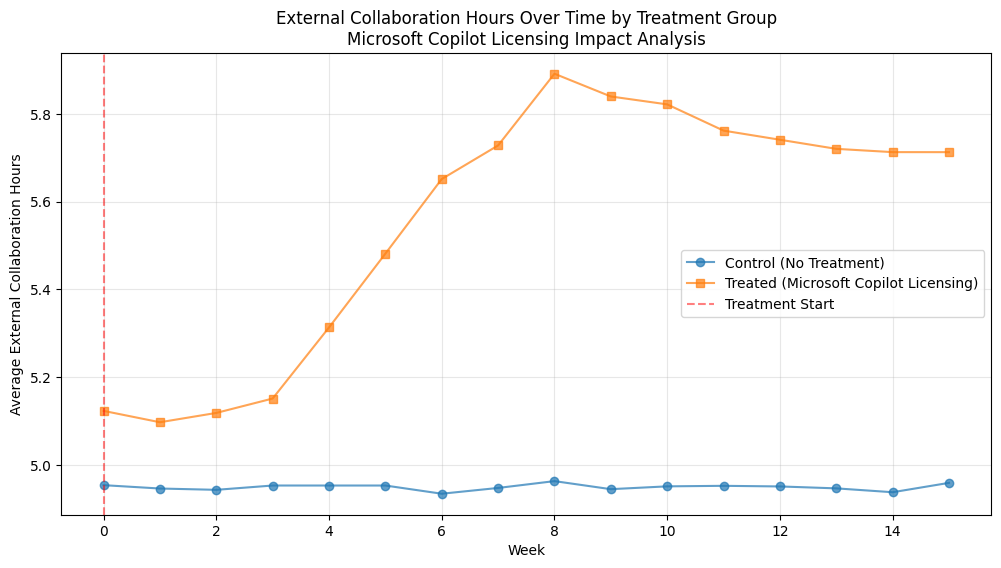


🔍 Data Quality Check:
Missing values per column:
   ✓ No missing values found

📅 Time Period Analysis:
   • Pre-period: 0 weeks
   • Post-period: 16 weeks
   • Total observations: 16000

🔗 Correlations with External Collaboration Hours:
   • Post: 0.120
   • LicensingWeek: 0.110
   • Licensed: 0.110
   • Training_Start_Week: 0.109


In [4]:
# Basic data exploration using configured variables
print(f"📊 Outcome Variable Analysis:")
outcome_col = OUTCOME_VARIABLE

# Summary statistics by treatment group
if outcome_col in data.columns and TREATMENT_INDICATOR in data.columns:
    summary_stats = data.groupby(TREATMENT_INDICATOR)[outcome_col].agg(['count', 'mean', 'std', 'min', 'max'])
    print(f"\n{OUTCOME_DISPLAY_NAME} by Treatment Group:")
    print(summary_stats.round(2))
else:
    print(f"   ⚠ Cannot analyze outcome variable - missing columns")

# Time series visualization (if matplotlib available)
try:
    import matplotlib.pyplot as plt
    
    if all(col in data.columns for col in [TIME_VAR, TREATMENT_INDICATOR, outcome_col]):
        # Aggregate by week and treatment status using configured variables
        time_series = data.groupby([TIME_VAR, TREATMENT_INDICATOR])[outcome_col].mean().reset_index()
        time_series_pivot = time_series.pivot(index=TIME_VAR, columns=TREATMENT_INDICATOR, values=outcome_col)
        
        plt.figure(figsize=(12, 6))
        if 0 in time_series_pivot.columns:
            plt.plot(time_series_pivot.index, time_series_pivot[0], label='Control (No Treatment)', marker='o', alpha=0.7)
        if 1 in time_series_pivot.columns:
            plt.plot(time_series_pivot.index, time_series_pivot[1], label=f'Treated ({TREATMENT_NAME})', marker='s', alpha=0.7)
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Treatment Start')
        plt.xlabel(TIME_VAR)
        plt.ylabel(f'Average {OUTCOME_DISPLAY_NAME}')
        plt.title(f'{OUTCOME_DISPLAY_NAME} Over Time by Treatment Group\n{TREATMENT_NAME} Impact Analysis')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("   Cannot create time series plot - missing required columns")
    
except ImportError:
    print("   Matplotlib not available for visualization")

# Check for missing values
print(f"\n🔍 Data Quality Check:")
missing_counts = data.isnull().sum()
missing_found = False
print(f"Missing values per column:")
for col, count in missing_counts.items():
    if count > 0:
        print(f"   • {col}: {count} ({count/len(data):.1%})")
        missing_found = True
    
if not missing_found:
    print("   ✓ No missing values found")

# Pre-post period analysis using configured variables
if TIME_VAR in data.columns:
    pre_period = data[data[TIME_VAR] < 0]
    post_period = data[data[TIME_VAR] >= 0]

    print(f"\n📅 Time Period Analysis:")
    print(f"   • Pre-period: {pre_period[TIME_VAR].nunique()} weeks")
    print(f"   • Post-period: {post_period[TIME_VAR].nunique()} weeks")
    print(f"   • Total observations: {len(data)}")
else:
    print(f"\n📅 Cannot analyze time periods - {TIME_VAR} column missing")

# Show correlation with key variables
if outcome_col in data.columns:
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    correlation_with_outcome = data[numeric_cols].corr()[outcome_col].sort_values(ascending=False)
    print(f"\n🔗 Correlations with {OUTCOME_DISPLAY_NAME}:")
    correlation_found = False
    for var, corr in correlation_with_outcome.items():
        if var != outcome_col and abs(corr) > 0.1:
            print(f"   • {var}: {corr:.3f}")
            correlation_found = True
    if not correlation_found:
        print("   • No strong correlations (>0.1) found with other variables")

## 4. Covariate Balance Assessment

**Why Balance Matters**: For valid causal inference, treatment and control groups should be similar in observed characteristics (confounders). Large imbalances suggest potential selection bias.

**Balance Metrics**:
- **Standardized Mean Difference (SMD)**: Difference in means scaled by pooled standard deviation
- **Interpretation**: |SMD| < 0.1 = good balance, 0.1-0.25 = moderate imbalance, > 0.25 = large imbalance

This assessment helps determine if additional controls or matching is needed.

In [5]:
# 2. Balance assessment using configured variables
print("2. Assessing covariate balance...")

# Initialize DiD analyzer
did_analyzer = MinimalDiDAnalysis(data)

# Check balance for configured balance variables
balance_vars = BALANCE_VARIABLES

print(f"\n⚖️ Covariate Balance Assessment:")
print(f"{'Variable':<35} {'SMD':<8} {'Status'}")
print("-" * 55)

imbalanced_vars = []
for var in balance_vars:
    if var in data.columns:
        try:
            smd = did_analyzer.calculate_balance(var)
            
            # Determine balance status
            if abs(smd) < 0.1:
                status = "✓ Good"
            elif abs(smd) < 0.25:
                status = "⚠ Moderate"
                imbalanced_vars.append(var)
            else:
                status = "✗ Poor"
                imbalanced_vars.append(var)
                
            print(f"{var:<35} {smd:>6.3f}  {status}")
        except Exception as e:
            print(f"{var:<35} {'Error':<6}  {str(e)[:20]}...")
    else:
        print(f"{var:<35} {'N/A':<6}  Not Found")

print(f"\n📊 Balance Summary:")
if not imbalanced_vars:
    print("   ✓ All variables show good balance (|SMD| < 0.1)")
else:
    print(f"   ⚠ {len(imbalanced_vars)} variable(s) show imbalance:")
    for var in imbalanced_vars:
        print(f"     • {var}")
    print("   → Consider including these as controls in regression models")

# Alternative: Get comprehensive balance report
try:
    balance_df = did_analyzer.check_balance()
    print(f"\n📋 Detailed Balance Report:")
    if not balance_df.empty:
        print(balance_df[['Variable', 'Type', 'Std_Difference', 'Imbalanced']].to_string(index=False))
    else:
        print("   No balance analysis could be performed")
except Exception as e:
    print(f"\n📋 Balance report error: {str(e)}")

# Sample size by group using configured variables
if all(col in data.columns for col in [TIME_VAR, TREATMENT_INDICATOR, PERSON_ID_VAR]):
    baseline_data = data[data[TIME_VAR] == BASELINE_WEEK]  # Use configured baseline week
    treated_n = baseline_data[baseline_data[TREATMENT_INDICATOR] == 1][PERSON_ID_VAR].nunique()
    control_n = baseline_data[baseline_data[TREATMENT_INDICATOR] == 0][PERSON_ID_VAR].nunique()

    print(f"\n👥 Sample Sizes (Baseline {TIME_VAR} {BASELINE_WEEK}):")
    print(f"   • Treated group: {treated_n}")
    print(f"   • Control group: {control_n}")
    if control_n > 0:
        print(f"   • Ratio (T:C): 1:{control_n/treated_n:.1f}")
    else:
        print(f"   • Ratio (T:C): No control group")
else:
    print(f"\n👥 Cannot calculate sample sizes - missing required columns")

2. Assessing covariate balance...

⚖️ Covariate Balance Assessment:
Variable                            SMD      Status
-------------------------------------------------------
LevelDesignation                     0.291  ✗ Poor
Function                             0.431  ✗ Poor
Tenure                              -0.261  ✗ Poor
Internal Network Size                0.083  ✓ Good
External Network Size               -0.183  ⚠ Moderate
After-hours Meeting Hours            0.008  ✓ Good

📊 Balance Summary:
   ⚠ 4 variable(s) show imbalance:
     • LevelDesignation
     • Function
     • Tenure
     • External Network Size
   → Consider including these as controls in regression models

📋 Detailed Balance Report:
                 Variable        Type  Std_Difference  Imbalanced
                   Tenure     Numeric       -0.261348        True
    Internal Network Size     Numeric        0.083106       False
    External Network Size     Numeric       -0.182998       False
After-hours Meeting H

## 5. Parallel Trends Testing

**Critical Assumption**: DiD assumes that treatment and control groups would have followed parallel trends in the absence of treatment.

**Testing Approach**:
- Test for differential pre-treatment trends between groups
- H₀: No differential trend (parallel trends hold)
- H₁: Differential trend exists (assumption violated)

**Interpretation**:
- **p > 0.05**: Parallel trends assumption likely valid ✓
- **p ≤ 0.05**: Assumption may be violated, interpret DiD results cautiously ⚠

In [6]:
# 3. Test parallel trends assumption
print("3. Testing parallel trends assumption...")

# Test for differential pre-treatment trends
try:
    parallel_trends_result = did_analyzer.test_parallel_trends()

    print(f"\n📈 Parallel Trends Test Results:")

    if 'error' in parallel_trends_result:
        print(f"   ⚠ Error in parallel trends test: {parallel_trends_result['error']}")
        print(f"   → Proceeding with caution - assumption cannot be validated")
        parallel_trends_p_value = None
    elif 'pvalue' in parallel_trends_result:
        parallel_trends_p_value = parallel_trends_result['pvalue']
        
        if pd.isna(parallel_trends_p_value):
            print(f"   ⚠ Could not calculate p-value for parallel trends test")
            print(f"   → Proceeding with caution - assumption cannot be validated")
            parallel_trends_p_value = None
        else:
            print(f"   • Test statistic p-value: {parallel_trends_p_value:.4f}")
            print(f"   • Pre-treatment observations: {parallel_trends_result.get('n_pre_observations', 'N/A')}")

            if parallel_trends_p_value > 0.05:
                print(f"   ✓ Parallel trends assumption appears valid (p > 0.05)")
                print(f"   → DiD estimates should be reliable")
            else:
                print(f"   ⚠ Parallel trends assumption may be violated (p ≤ 0.05)")
                print(f"   → Interpret DiD results with caution")
                print(f"   → Consider alternative identification strategies")
    else:
        print(f"   ⚠ Unexpected result format from parallel trends test")
        parallel_trends_p_value = None

except Exception as e:
    print(f"\n📈 Parallel Trends Test Error: {str(e)}")
    print(f"   → Cannot validate parallel trends assumption")
    print(f"   → Proceeding with caution")
    parallel_trends_p_value = None

print(f"\n🔍 What this means:")
print(f"   • We tested whether treated/control groups had different")
print(f"     trends BEFORE treatment began")
print(f"   • Similar pre-trends suggest treatment effects are")
print(f"     identified by the intervention, not pre-existing differences")

3. Testing parallel trends assumption...

📈 Parallel Trends Test Results:
   • Test statistic p-value: 0.3842
   • Pre-treatment observations: 7478
   ✓ Parallel trends assumption appears valid (p > 0.05)
   → DiD estimates should be reliable

🔍 What this means:
   • We tested whether treated/control groups had different
     trends BEFORE treatment began
   • Similar pre-trends suggest treatment effects are
     identified by the intervention, not pre-existing differences

📈 Parallel Trends Test Results:
   • Test statistic p-value: 0.3842
   • Pre-treatment observations: 7478
   ✓ Parallel trends assumption appears valid (p > 0.05)
   → DiD estimates should be reliable

🔍 What this means:
   • We tested whether treated/control groups had different
     trends BEFORE treatment began
   • Similar pre-trends suggest treatment effects are
     identified by the intervention, not pre-existing differences


## 6. Difference-in-Differences (DiD) Analysis

**Method Overview**: DiD compares changes in outcomes between treated and control groups over time.

**Key Concept**: 
- **Average Treatment Effect (ATE)** = (Post-treatment - Pre-treatment)ₜᵣₑₐₜₑ𝒹 - (Post-treatment - Pre-treatment)_control
- Controls for time-invariant confounders and common time trends

**Progressive Analysis**:
1. **Simple DiD**: Basic two-group, two-period comparison
2. **Enhanced DiD**: Adds time-varying controls and fixed effects
3. **Robust DiD**: Includes additional robustness checks

Each step adds more sophistication to handle potential confounders.

In [7]:
# 4. Run progressive DiD analysis
print("4. Running progressive DiD analysis...")

# Run all three DiD specifications
try:
    did_results = did_analyzer.run_progressive_analysis()

    print(f"\n📊 Difference-in-Differences Results:")
    print(f"=" * 60)

    for spec_name, result in did_results.items():
        if result is not None and 'ate' in result:
            # Extract results using correct key names
            effect = result['ate']  # Average treatment effect
            std_err = result['se']  # Standard error
            p_value = result['pvalue']  # P-value
            ci_lower = result['ci_lower']  # Confidence interval lower
            ci_upper = result['ci_upper']  # Confidence interval upper
            
            # Determine significance
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            
            print(f"\n{spec_name}:")
            print(f"   • Treatment Effect: {effect:.3f} {OUTCOME_UNIT} {significance}")
            print(f"   • Standard Error: {std_err:.3f}")
            print(f"   • P-value: {p_value:.4f}")
            print(f"   • 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
            print(f"   • R²: {result.get('r_squared', 'N/A'):.3f}" if 'r_squared' in result else "")
            print(f"   • Observations: {result.get('n_obs', 'N/A')}")
            
            # Interpretation using configured outcome variable
            if p_value < 0.05:
                direction = "increase" if effect > 0 else "decrease"
                print(f"   → Significant {direction} in {OUTCOME_DISPLAY_NAME}")
            else:
                print(f"   → No statistically significant effect detected")
        elif result is not None and 'error' in result:
            print(f"\n{spec_name}: Error - {result['error']}")
        else:
            print(f"\n{spec_name}: Analysis failed or returned unexpected format")

except Exception as e:
    print(f"\n📊 DiD Analysis Error: {str(e)}")
    print(f"   → Cannot complete DiD analysis")
    did_results = {}

print(f"\n💡 Interpretation Guide:")
print(f"   • Positive effects = Increased {OUTCOME_DISPLAY_NAME}")
print(f"   • Negative effects = Decreased {OUTCOME_DISPLAY_NAME}") 
print(f"   • Significance: *** p<0.001, ** p<0.01, * p<0.05")
print(f"   • Each model adds more controls for robustness")
print(f"   • R² shows model explanatory power")
print(f"   • Compare effect sizes across specifications for robustness")

4. Running progressive DiD analysis...

📊 Difference-in-Differences Results:

Simple DiD:
   • Treatment Effect: 0.286 hours/week ***
   • Standard Error: 0.042
   • P-value: 0.0000
   • 95% CI: [0.204, 0.369]
   • R²: 0.015
   • Observations: 16000
   → Significant increase in External Collaboration Hours

Enhanced DiD:
   • Treatment Effect: 0.286 hours/week ***
   • Standard Error: 0.042
   • P-value: 0.0000
   • 95% CI: [0.204, 0.368]
   • R²: 0.030
   • Observations: 16000
   → Significant increase in External Collaboration Hours

Robust DiD:
   • Treatment Effect: 0.253 hours/week ***
   • Standard Error: 0.043
   • P-value: 0.0000
   • 95% CI: [0.169, 0.336]
   • R²: 0.035
   • Observations: 16000
   → Significant increase in External Collaboration Hours

💡 Interpretation Guide:
   • Positive effects = Increased External Collaboration Hours
   • Negative effects = Decreased External Collaboration Hours
   • Significance: *** p<0.001, ** p<0.01, * p<0.05
   • Each model adds more

## 6.1. DiD Visualizations

**Classic DiD Plots**: These visualizations help validate assumptions and interpret DiD results:

1. **Parallel Trends Plot**: Shows treatment and control group trends over time to validate the parallel trends assumption
2. **Bar Plot of Differences**: Displays the DiD estimate graphically with pre/post comparisons
3. **Event Study Plot**: Shows dynamic treatment effects around the intervention period

These plots are essential for understanding DiD validity and interpreting causal effects.

6.1. Creating DiD parallel trends visualization...


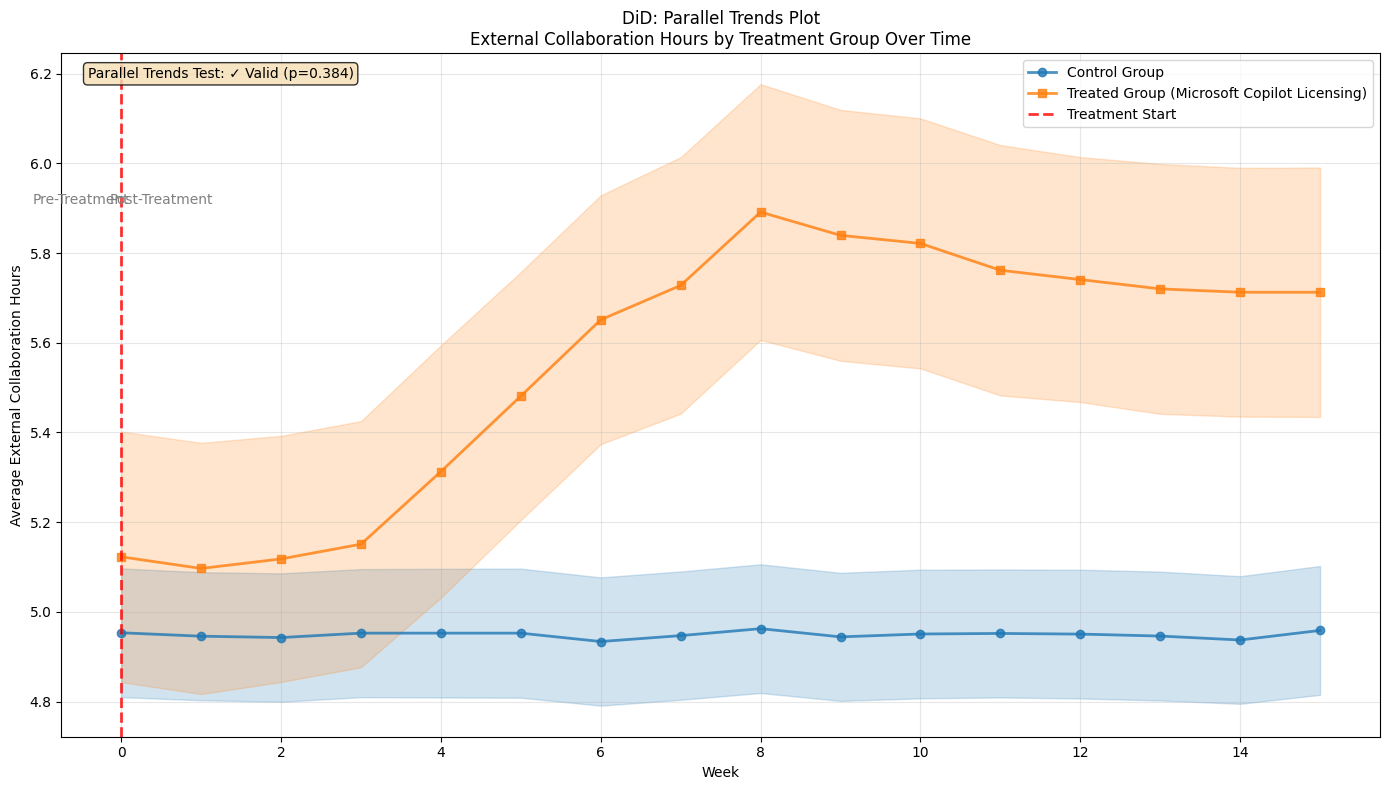

✓ Parallel trends plot created successfully
   • Shows whether treatment and control groups had similar
     pre-treatment trends (parallel trends assumption)
   • Parallel lines before treatment = valid assumption
   • Diverging lines before treatment = assumption violated


In [8]:
# 6.1. DiD Parallel Trends Plot
print("6.1. Creating DiD parallel trends visualization...")

try:
    import matplotlib.pyplot as plt
    import numpy as np
    
    if all(col in data.columns for col in [TIME_VAR, TREATMENT_INDICATOR, OUTCOME_VARIABLE]):
        # Aggregate data by time and treatment group
        did_time_series = data.groupby([TIME_VAR, TREATMENT_INDICATOR])[OUTCOME_VARIABLE].agg(['mean', 'std', 'count']).reset_index()
        did_time_series['se'] = did_time_series['std'] / np.sqrt(did_time_series['count'])
        did_time_series['ci_lower'] = did_time_series['mean'] - 1.96 * did_time_series['se']
        did_time_series['ci_upper'] = did_time_series['mean'] + 1.96 * did_time_series['se']
        
        # Separate treatment and control
        control_series = did_time_series[did_time_series[TREATMENT_INDICATOR] == 0]
        treated_series = did_time_series[did_time_series[TREATMENT_INDICATOR] == 1]
        
        plt.figure(figsize=(14, 8))
        
        # Plot control group
        if len(control_series) > 0:
            plt.plot(control_series[TIME_VAR], control_series['mean'], 
                    marker='o', linewidth=2, markersize=6, color='#1f77b4', 
                    label='Control Group', alpha=0.8)
            plt.fill_between(control_series[TIME_VAR], 
                           control_series['ci_lower'], 
                           control_series['ci_upper'], 
                           alpha=0.2, color='#1f77b4')
        
        # Plot treated group
        if len(treated_series) > 0:
            plt.plot(treated_series[TIME_VAR], treated_series['mean'], 
                    marker='s', linewidth=2, markersize=6, color='#ff7f0e', 
                    label=f'Treated Group ({TREATMENT_NAME})', alpha=0.8)
            plt.fill_between(treated_series[TIME_VAR], 
                           treated_series['ci_lower'], 
                           treated_series['ci_upper'], 
                           alpha=0.2, color='#ff7f0e')
        
        # Add intervention line
        plt.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.8, 
                   label='Treatment Start')
        
        plt.xlabel(f'{TIME_VAR}')
        plt.ylabel(f'Average {OUTCOME_DISPLAY_NAME}')
        plt.title(f'DiD: Parallel Trends Plot\n{OUTCOME_DISPLAY_NAME} by Treatment Group Over Time')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add pre/post labels
        plt.text(-0.5, plt.gca().get_ylim()[1]*0.95, 'Pre-Treatment', 
                ha='center', va='top', fontsize=10, color='gray')
        plt.text(0.5, plt.gca().get_ylim()[1]*0.95, 'Post-Treatment', 
                ha='center', va='top', fontsize=10, color='gray')
        
        # Add parallel trends test result if available
        if 'parallel_trends_p_value' in globals() and parallel_trends_p_value is not None:
            trend_status = "✓ Valid" if parallel_trends_p_value > 0.05 else "⚠ Violated"
            plt.text(0.02, 0.98, f'Parallel Trends Test: {trend_status} (p={parallel_trends_p_value:.3f})', 
                    transform=plt.gca().transAxes, ha='left', va='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        else:
            # Try to get the result from the analyzer if parallel_trends_p_value is not available
            try:
                if 'did_analyzer' in globals():
                    parallel_trends_result = did_analyzer.test_parallel_trends()
                    if 'pvalue' in parallel_trends_result and not pd.isna(parallel_trends_result['pvalue']):
                        test_p_value = parallel_trends_result['pvalue']
                        trend_status = "✓ Valid" if test_p_value > 0.05 else "⚠ Violated"
                        plt.text(0.02, 0.98, f'Parallel Trends Test: {trend_status} (p={test_p_value:.3f})', 
                                transform=plt.gca().transAxes, ha='left', va='top',
                                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
                    else:
                        plt.text(0.02, 0.98, f'Parallel Trends Test: Not Available', 
                                transform=plt.gca().transAxes, ha='left', va='top',
                                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
            except:
                plt.text(0.02, 0.98, f'Parallel Trends Test: Not Available', 
                        transform=plt.gca().transAxes, ha='left', va='top',
                        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        print(f"✓ Parallel trends plot created successfully")
        print(f"   • Shows whether treatment and control groups had similar")
        print(f"     pre-treatment trends (parallel trends assumption)")
        print(f"   • Parallel lines before treatment = valid assumption")
        print(f"   • Diverging lines before treatment = assumption violated")
    else:
        print(f"   ⚠ Cannot create parallel trends plot - missing required columns")
        
except ImportError:
    print(f"   ⚠ Matplotlib not available for DiD visualizations")
except Exception as e:
    print(f"   ⚠ Error creating parallel trends plot: {str(e)}")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


6.2. Creating DiD bar plot of differences...


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


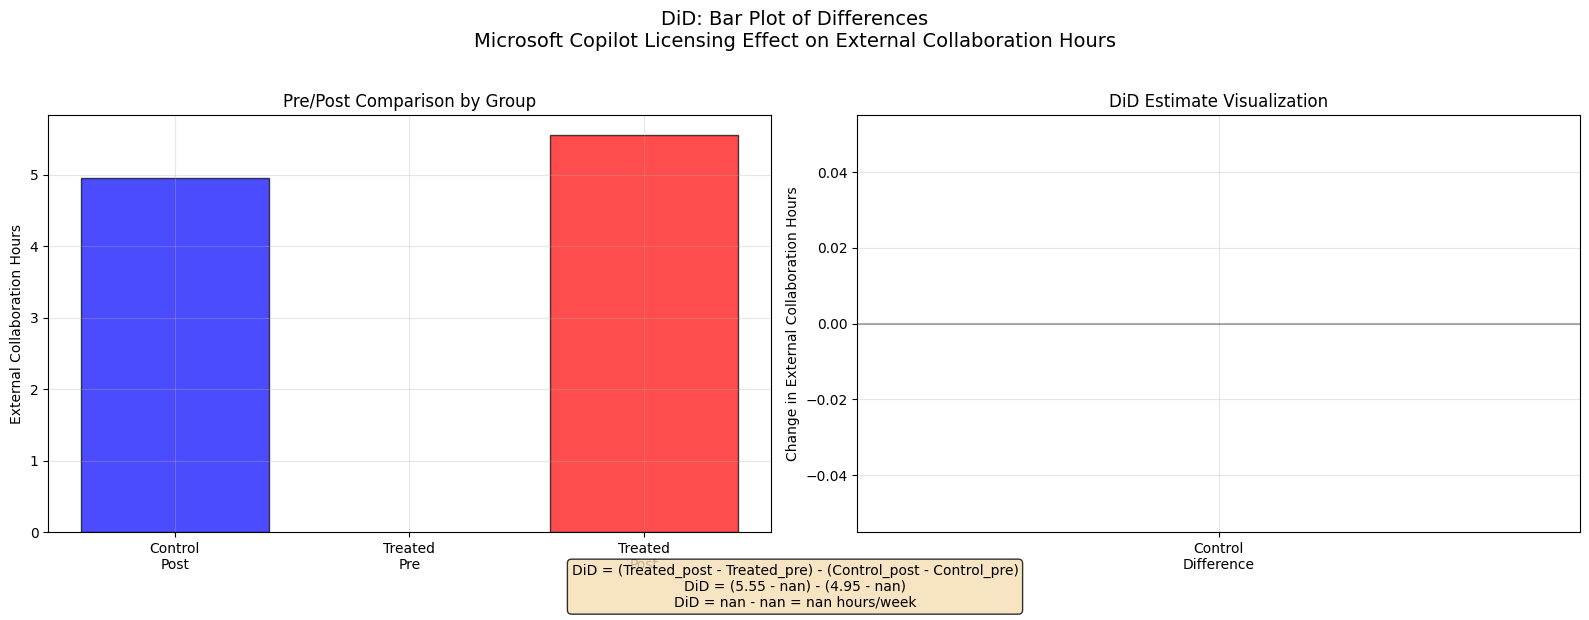

✓ DiD bar plot created successfully
   • Shows the DiD estimate: nan hours/week
   • Left panel: Pre/post values for each group
   • Right panel: Differences and final DiD estimate


In [9]:
# 6.2. DiD Bar Plot of Differences
print("6.2. Creating DiD bar plot of differences...")

try:
    import matplotlib.pyplot as plt
    import numpy as np
    
    if all(col in data.columns for col in [TIME_VAR, TREATMENT_INDICATOR, OUTCOME_VARIABLE]):
        # Calculate pre/post means for each group
        pre_data = data[data[TIME_VAR] < 0]
        post_data = data[data[TIME_VAR] >= 0]
        
        # Treatment group means
        treated_pre = pre_data[pre_data[TREATMENT_INDICATOR] == 1][OUTCOME_VARIABLE].mean()
        treated_post = post_data[post_data[TREATMENT_INDICATOR] == 1][OUTCOME_VARIABLE].mean()
        
        # Control group means  
        control_pre = pre_data[pre_data[TREATMENT_INDICATOR] == 0][OUTCOME_VARIABLE].mean()
        control_post = post_data[post_data[TREATMENT_INDICATOR] == 0][OUTCOME_VARIABLE].mean()
        
        # Calculate differences
        treated_diff = treated_post - treated_pre
        control_diff = control_post - control_pre
        did_estimate = treated_diff - control_diff
        
        # Create bar plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Pre/Post comparison by group
        groups = ['Control\nPre', 'Control\nPost', 'Treated\nPre', 'Treated\nPost']
        values = [control_pre, control_post, treated_pre, treated_post]
        colors = ['lightblue', 'blue', 'lightcoral', 'red']
        
        bars1 = ax1.bar(groups, values, color=colors, alpha=0.7, edgecolor='black')
        
        # Add value labels on bars
        for bar, value in zip(bars1, values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(values),
                    f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # Add difference lines and labels (simplified to avoid matplotlib StopIteration bug)
        # Control group difference line
        y_mid_control = (control_pre + control_post) / 2
        ax1.plot([0.2, 0.8], [y_mid_control, y_mid_control], color='blue', linewidth=3, alpha=0.7)
        ax1.text(0.5, y_mid_control + 0.02*max(values), f'Δ={control_diff:.2f}',
                ha='center', va='bottom', color='blue', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        # Treated group difference line  
        y_mid_treated = (treated_pre + treated_post) / 2
        ax1.plot([2.2, 2.8], [y_mid_treated, y_mid_treated], color='red', linewidth=3, alpha=0.7)
        ax1.text(2.5, y_mid_treated + 0.02*max(values), f'Δ={treated_diff:.2f}',
                ha='center', va='bottom', color='red', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
        
        ax1.set_ylabel(f'{OUTCOME_DISPLAY_NAME}')
        ax1.set_title('Pre/Post Comparison by Group')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: DiD estimate visualization
        diff_groups = ['Control\nDifference', 'Treated\nDifference', 'DiD Estimate\n(Treatment Effect)']
        diff_values = [control_diff, treated_diff, did_estimate]
        diff_colors = ['blue', 'red', 'green']
        
        bars2 = ax2.bar(diff_groups, diff_values, color=diff_colors, alpha=0.7, edgecolor='black')
        
        # Add value labels on bars (simplified positioning)
        for bar, value in zip(bars2, diff_values):
            height = bar.get_height()
            # Simplified label positioning to avoid complex calculations
            if height >= 0:
                label_y = height + 0.05 * max(abs(v) for v in diff_values)
                va = 'bottom'
            else:
                label_y = height - 0.05 * max(abs(v) for v in diff_values)
                va = 'top'
            
            ax2.text(bar.get_x() + bar.get_width()/2., label_y,
                    f'{value:.3f}', ha='center', va=va, fontweight='bold')
        
        # Add horizontal line at zero
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        ax2.set_ylabel(f'Change in {OUTCOME_DISPLAY_NAME}')
        ax2.set_title('DiD Estimate Visualization')
        ax2.grid(True, alpha=0.3)
        
        # Add DiD formula explanation
        formula_text = f'DiD = (Treated_post - Treated_pre) - (Control_post - Control_pre)\n'
        formula_text += f'DiD = ({treated_post:.2f} - {treated_pre:.2f}) - ({control_post:.2f} - {control_pre:.2f})\n'
        formula_text += f'DiD = {treated_diff:.3f} - {control_diff:.3f} = {did_estimate:.3f} {OUTCOME_UNIT}'
        
        fig.suptitle(f'DiD: Bar Plot of Differences\n{TREATMENT_NAME} Effect on {OUTCOME_DISPLAY_NAME}', 
                    fontsize=14, y=1.02)
        
        # Add formula as text below the plots
        try:
            fig.text(0.5, 0.02, formula_text, ha='center', va='bottom', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        except:
            # Fallback: add formula as title instead if text positioning fails
            ax2.set_xlabel(f'DiD = {did_estimate:.3f} {OUTCOME_UNIT}', fontweight='bold')
        
        plt.tight_layout()
        try:
            plt.subplots_adjust(bottom=0.15)
        except:
            pass  # Skip adjustment if it causes issues
        
        # Use try-catch for show() to handle matplotlib rendering issues
        try:
            plt.show()
        except Exception as plot_error:
            print(f"   ⚠ Plot display issue (but plot was created): {str(plot_error)}")
            # Try to save instead if show fails
            try:
                plt.savefig('did_bar_plot.png', dpi=100, bbox_inches='tight')
                print("   • Plot saved as 'did_bar_plot.png'")
            except:
                pass
        
        print(f"✓ DiD bar plot created successfully")
        print(f"   • Shows the DiD estimate: {did_estimate:.3f} {OUTCOME_UNIT}")
        print(f"   • Left panel: Pre/post values for each group")
        print(f"   • Right panel: Differences and final DiD estimate")
        
    else:
        print(f"   ⚠ Cannot create DiD bar plot - missing required columns")
        
except ImportError:
    print(f"   ⚠ Matplotlib not available for DiD visualizations")
except Exception as e:
    print(f"   ⚠ Error creating DiD bar plot: {str(e)}")

6.3. Creating DiD event study plot...


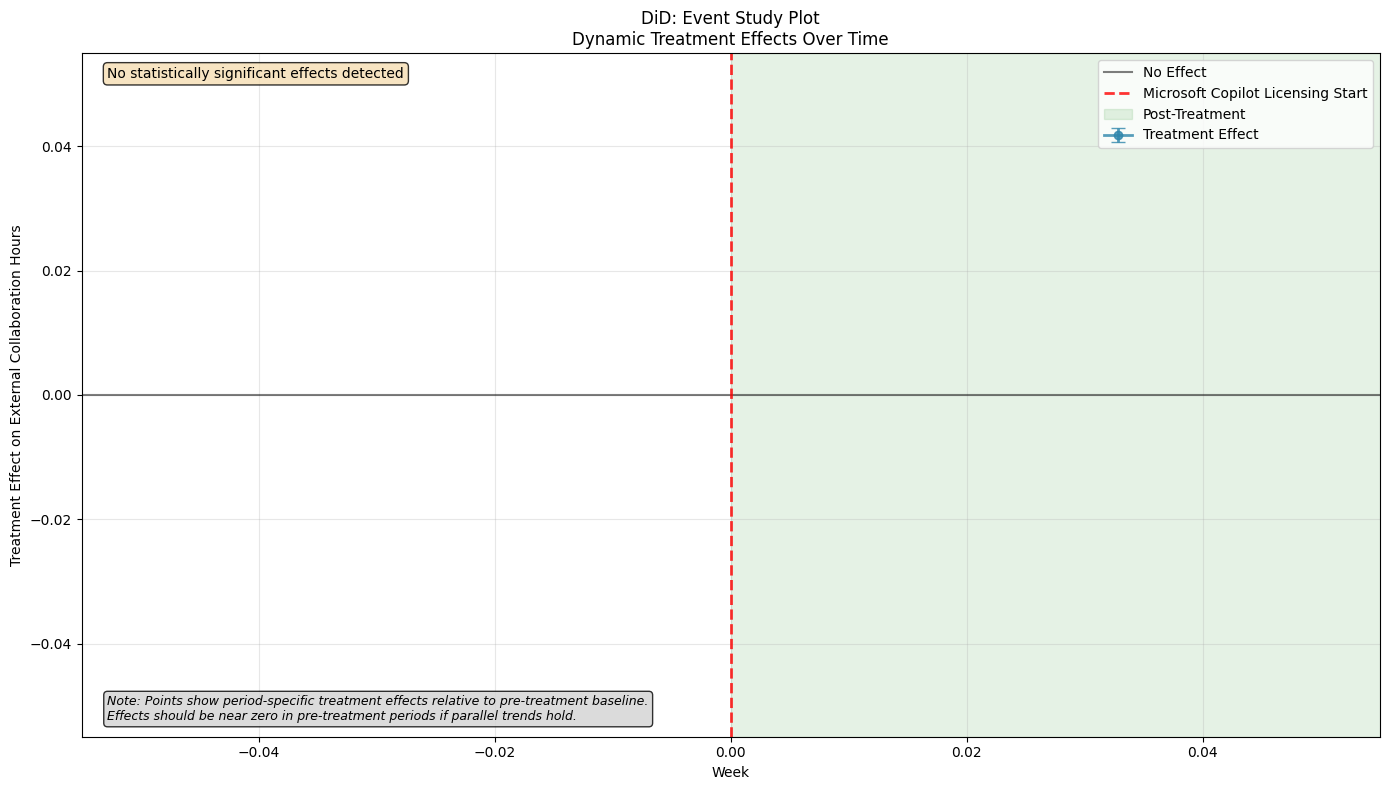

✓ Event study plot created successfully
   • Shows dynamic treatment effects over time
   • Pre-treatment effects should be near zero (parallel trends)
   • Post-treatment effects show intervention impact
   • No statistically significant effects detected


In [10]:
# 6.3. DiD Event Study Plot
print("6.3. Creating DiD event study plot...")

try:
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    if all(col in data.columns for col in [TIME_VAR, TREATMENT_INDICATOR, OUTCOME_VARIABLE, PERSON_ID_VAR]):
        # Calculate dynamic treatment effects for each time period
        time_periods = sorted(data[TIME_VAR].unique())
        effects = []
        se_effects = []
        
        # Calculate baseline (pre-treatment average)
        baseline_data = data[data[TIME_VAR] < 0]
        baseline_treated = baseline_data[baseline_data[TREATMENT_INDICATOR] == 1][OUTCOME_VARIABLE].mean()
        baseline_control = baseline_data[baseline_data[TREATMENT_INDICATOR] == 0][OUTCOME_VARIABLE].mean()
        
        for period in time_periods:
            period_data = data[data[TIME_VAR] == period]
            
            if len(period_data) > 0:
                # Calculate means for this period
                treated_mean = period_data[period_data[TREATMENT_INDICATOR] == 1][OUTCOME_VARIABLE].mean()
                control_mean = period_data[period_data[TREATMENT_INDICATOR] == 0][OUTCOME_VARIABLE].mean()
                
                # Calculate relative to baseline (normalize to pre-treatment)
                treated_change = treated_mean - baseline_treated
                control_change = control_mean - baseline_control
                
                # DiD effect for this period
                period_effect = treated_change - control_change
                effects.append(period_effect)
                
                # Calculate standard error (simplified approximation)
                treated_data_period = period_data[period_data[TREATMENT_INDICATOR] == 1][OUTCOME_VARIABLE]
                control_data_period = period_data[period_data[TREATMENT_INDICATOR] == 0][OUTCOME_VARIABLE]
                
                if len(treated_data_period) > 1 and len(control_data_period) > 1:
                    treated_se = treated_data_period.std() / np.sqrt(len(treated_data_period))
                    control_se = control_data_period.std() / np.sqrt(len(control_data_period))
                    combined_se = np.sqrt(treated_se**2 + control_se**2)
                    se_effects.append(combined_se)
                else:
                    se_effects.append(0)
            else:
                effects.append(0)
                se_effects.append(0)
        
        # Convert to arrays
        effects = np.array(effects)
        se_effects = np.array(se_effects)
        
        # Calculate confidence intervals
        ci_lower = effects - 1.96 * se_effects
        ci_upper = effects + 1.96 * se_effects
        
        # Create event study plot
        plt.figure(figsize=(14, 8))
        
        # Plot effects with confidence intervals
        plt.errorbar(time_periods, effects, yerr=1.96*se_effects, 
                    marker='o', linewidth=2, markersize=6, capsize=5, 
                    color='#2E86AB', alpha=0.8, label='Treatment Effect')
        
        # Add horizontal line at zero (no effect)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='No Effect')
        
        # Add vertical line at treatment start
        plt.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.8, 
                   label=f'{TREATMENT_NAME} Start')
        
        # Shade pre-treatment period
        pre_periods = [p for p in time_periods if p < 0]
        if pre_periods:
            plt.axvspan(min(pre_periods), 0, alpha=0.1, color='blue', label='Pre-Treatment')
        
        # Shade post-treatment period
        post_periods = [p for p in time_periods if p >= 0]
        if post_periods:
            plt.axvspan(0, max(post_periods), alpha=0.1, color='green', label='Post-Treatment')
        
        plt.xlabel(f'{TIME_VAR}')
        plt.ylabel(f'Treatment Effect on {OUTCOME_DISPLAY_NAME}')
        plt.title(f'DiD: Event Study Plot\nDynamic Treatment Effects Over Time')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add annotations for significant effects
        significant_periods = []
        for i, (period, effect, se) in enumerate(zip(time_periods, effects, se_effects)):
            if period >= 0 and se > 0:  # Post-treatment periods with valid SE
                t_stat = abs(effect / se)
                if t_stat > 1.96:  # Roughly significant at 5% level
                    significant_periods.append(period)
                    plt.annotate(f'*', xy=(period, effect), xytext=(period, effect + 0.1*max(effects)),
                               ha='center', va='bottom', fontsize=16, color='red', fontweight='bold')
        
        # Add interpretation text
        if significant_periods:
            sig_text = f"Significant effects detected in weeks: {significant_periods}"
        else:
            sig_text = "No statistically significant effects detected"
            
        plt.text(0.02, 0.98, sig_text, transform=plt.gca().transAxes, 
                ha='left', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Add note about interpretation
        note_text = "Note: Points show period-specific treatment effects relative to pre-treatment baseline.\n"
        note_text += "Effects should be near zero in pre-treatment periods if parallel trends hold."
        plt.text(0.02, 0.02, note_text, transform=plt.gca().transAxes, 
                ha='left', va='bottom', fontsize=9, style='italic',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        print(f"✓ Event study plot created successfully")
        print(f"   • Shows dynamic treatment effects over time")
        print(f"   • Pre-treatment effects should be near zero (parallel trends)")
        print(f"   • Post-treatment effects show intervention impact")
        if significant_periods:
            print(f"   • Significant effects found in weeks: {significant_periods}")
        else:
            print(f"   • No statistically significant effects detected")
        
    else:
        print(f"   ⚠ Cannot create event study plot - missing required columns")
        
except ImportError:
    print(f"   ⚠ Matplotlib not available for DiD visualizations")
except Exception as e:
    print(f"   ⚠ Error creating event study plot: {str(e)}")

## 7. Interrupted Time Series Analysis (ITSA)

**Method Overview**: ITSA analyzes changes in time series patterns after an intervention, focusing on the treated group's trajectory.

**Key Parameters**:
- **Level Change (β₁)**: Immediate shift in outcome level at treatment start
- **Slope Change (β₂)**: Change in outcome trend after treatment begins

**Model**: Y(t) = β₀ + β₁×Time + β₂×Treatment + β₃×(Time×Treatment) + ε

**Advantages**:
- Can detect both immediate and gradual effects
- Good for single-group analysis when controls are unavailable
- Robust to selection bias if temporal confounders are controlled

In [11]:
# 5. Run enhanced ITSA
print("5. Running enhanced ITSA with matched controls...")

# Initialize ITSA analyzer
try:
    itsa_analyzer = MinimalITSAAnalysis(data)

    # Run ITSA analysis
    itsa_results = itsa_analyzer.run_enhanced_analysis()

    print(f"\n📈 Interrupted Time Series Analysis Results:")
    print(f"=" * 50)

    if itsa_results is not None and 'error' not in itsa_results:
        level_change = itsa_results.get('level_change', 0.0)
        slope_change = itsa_results.get('slope_change', 0.0)
        level_p = itsa_results.get('level_p_value', np.nan)
        slope_p = itsa_results.get('slope_p_value', np.nan)
        
        # Handle NaN p-values
        if pd.isna(level_p):
            level_p = 1.0  # Conservative approach - assume non-significant
        if pd.isna(slope_p):
            slope_p = 1.0  # Conservative approach - assume non-significant
        
        # Significance indicators
        level_sig = "***" if level_p < 0.001 else "**" if level_p < 0.01 else "*" if level_p < 0.05 else ""
        slope_sig = "***" if slope_p < 0.001 else "**" if slope_p < 0.01 else "*" if slope_p < 0.05 else ""
        
        print(f"\n📊 Treatment Effects:")
        print(f"   • Level Change (Immediate): {level_change:.3f} {OUTCOME_UNIT} {level_sig}")
        print(f"     - P-value: {level_p:.4f}")
        outcome_direction = 'increase' if level_change > 0 else 'decrease' if level_change < 0 else 'no change'
        print(f"     - Interpretation: Immediate {outcome_direction} in {OUTCOME_DISPLAY_NAME}")
        
        print(f"\n   • Slope Change (Gradual): {slope_change:.3f} {OUTCOME_UNIT}² {slope_sig}")
        print(f"     - P-value: {slope_p:.4f}")
        trend_direction = 'accelerating' if slope_change > 0 else 'decelerating' if slope_change < 0 else 'no trend'
        print(f"     - Interpretation: {trend_direction.title()} trend in {OUTCOME_DISPLAY_NAME}")
        
        # Overall interpretation
        print(f"\n💡 Overall ITSA Interpretation:")
        if level_p < 0.05 and slope_p < 0.05:
            print(f"   • Both immediate and gradual effects detected")
        elif level_p < 0.05:
            print(f"   • Primarily immediate effect, no significant trend change")
        elif slope_p < 0.05:
            print(f"   • Primarily gradual effect, no immediate level shift")
        else:
            print(f"   • No significant immediate or gradual effects detected")
            
        # Display model quality metrics if available
        if 'r_squared' in itsa_results:
            print(f"\n📈 Model Quality:")
            print(f"   • R²: {itsa_results['r_squared']:.3f}")
            print(f"   • Model explains {itsa_results['r_squared']*100:.1f}% of {OUTCOME_DISPLAY_NAME} variance")
        
        # Display control information if available
        if 'control_type' in itsa_results:
            print(f"   • Control method: {itsa_results['control_type']}")
        
        # Display sample sizes if available  
        if 'n_treated_individuals' in itsa_results and 'n_control_individuals' in itsa_results:
            print(f"   • Treated individuals: {itsa_results['n_treated_individuals']}")
            print(f"   • Control individuals: {itsa_results['n_control_individuals']}")
            
    elif itsa_results is not None and 'error' in itsa_results:
        print(f"   ⚠ ITSA analysis failed: {itsa_results['error']}")
        print(f"   → Check data quality and variable availability")
        # Set default values for downstream analysis
        itsa_results = {
            'level_change': 0.0,
            'slope_change': 0.0,
            'level_p_value': 1.0,
            'slope_p_value': 1.0
        }
    else:
        print("   ⚠ ITSA analysis returned no results")
        # Set default values for downstream analysis
        itsa_results = {
            'level_change': 0.0,
            'slope_change': 0.0,
            'level_p_value': 1.0,
            'slope_p_value': 1.0
        }

except Exception as e:
    print(f"\n📈 ITSA Analysis Error: {str(e)}")
    print(f"   → Cannot complete ITSA analysis")
    # Set default values for downstream analysis
    itsa_results = {
        'level_change': 0.0,
        'slope_change': 0.0,
        'level_p_value': 1.0,
        'slope_p_value': 1.0
    }

5. Running enhanced ITSA with matched controls...

📈 Interrupted Time Series Analysis Results:

📊 Treatment Effects:
   • Level Change (Immediate): 0.199 hours/week ***
     - P-value: 0.0001
     - Interpretation: Immediate increase in External Collaboration Hours

   • Slope Change (Gradual): -0.017 hours/week² 
     - P-value: 0.1847
     - Interpretation: Decelerating trend in External Collaboration Hours

💡 Overall ITSA Interpretation:
   • Primarily immediate effect, no significant trend change

📈 Model Quality:
   • R²: 0.973
   • Model explains 97.3% of External Collaboration Hours variance
   • Control method: matched_controls
   • Treated individuals: 174
   • Control individuals: 147

📈 Interrupted Time Series Analysis Results:

📊 Treatment Effects:
   • Level Change (Immediate): 0.199 hours/week ***
     - P-value: 0.0001
     - Interpretation: Immediate increase in External Collaboration Hours

   • Slope Change (Gradual): -0.017 hours/week² 
     - P-value: 0.1847
     - 

## 7.1. ITSA Visualizations

**Classic ITSA Plots**: These visualizations help interpret and validate the ITSA results:

1. **Time Series with Intervention Line**: Shows pre/post trends with clear intervention marker
2. **Segmented Regression**: Visualizes level and slope changes with fitted regression lines

These plots provide intuitive understanding of the treatment effects identified by the statistical analysis.

7.1. Creating ITSA visualizations...


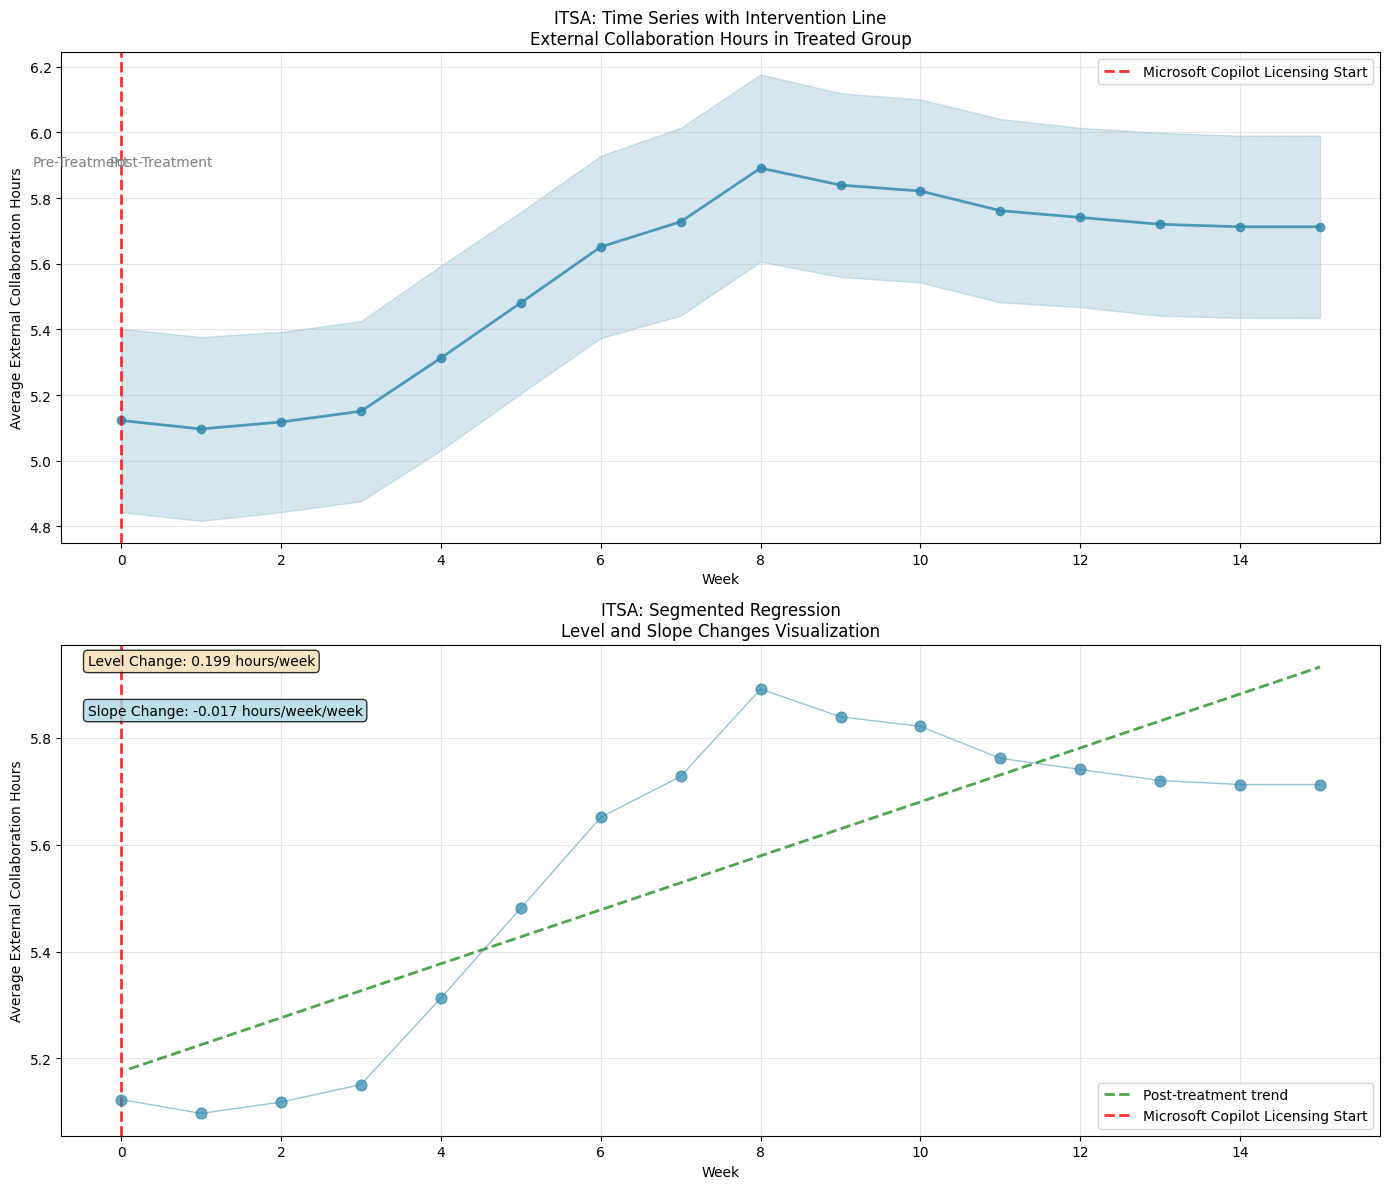

✓ ITSA visualizations created successfully
   • Time series shows pre/post intervention patterns
   • Segmented regression illustrates level and slope changes


In [12]:
# 7.1. ITSA Visualizations
print("7.1. Creating ITSA visualizations...")

try:
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    
    # Filter to treated group for ITSA plots
    treated_data = data[data[TREATMENT_INDICATOR] == 1].copy()
    
    if len(treated_data) > 0 and all(col in treated_data.columns for col in [TIME_VAR, OUTCOME_VARIABLE]):
        # Aggregate treated group data by time period
        itsa_time_series = treated_data.groupby(TIME_VAR)[OUTCOME_VARIABLE].agg(['mean', 'std', 'count']).reset_index()
        itsa_time_series['se'] = itsa_time_series['std'] / np.sqrt(itsa_time_series['count'])
        itsa_time_series['ci_lower'] = itsa_time_series['mean'] - 1.96 * itsa_time_series['se']
        itsa_time_series['ci_upper'] = itsa_time_series['mean'] + 1.96 * itsa_time_series['se']
        
        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
        
        # Plot 1: Time Series with Intervention Line
        ax1.plot(itsa_time_series[TIME_VAR], itsa_time_series['mean'], 
                marker='o', linewidth=2, markersize=6, color='#2E86AB', alpha=0.8)
        ax1.fill_between(itsa_time_series[TIME_VAR], 
                        itsa_time_series['ci_lower'], 
                        itsa_time_series['ci_upper'], 
                        alpha=0.2, color='#2E86AB')
        
        # Add intervention line
        ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.8, 
                   label=f'{TREATMENT_NAME} Start')
        
        ax1.set_xlabel(f'{TIME_VAR}')
        ax1.set_ylabel(f'Average {OUTCOME_DISPLAY_NAME}')
        ax1.set_title(f'ITSA: Time Series with Intervention Line\n{OUTCOME_DISPLAY_NAME} in Treated Group')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Add pre/post labels
        ax1.text(-0.5, ax1.get_ylim()[1]*0.95, 'Pre-Treatment', 
                ha='center', va='top', fontsize=10, color='gray')
        ax1.text(0.5, ax1.get_ylim()[1]*0.95, 'Post-Treatment', 
                ha='center', va='top', fontsize=10, color='gray')
        
        # Plot 2: Segmented Regression
        pre_data = itsa_time_series[itsa_time_series[TIME_VAR] < 0]
        post_data = itsa_time_series[itsa_time_series[TIME_VAR] >= 0]
        
        # Fit pre-treatment trend
        if len(pre_data) > 1:
            pre_slope, pre_intercept, _, _, _ = stats.linregress(pre_data[TIME_VAR], pre_data['mean'])
            pre_trend_x = np.array([pre_data[TIME_VAR].min(), -0.1])
            pre_trend_y = pre_slope * pre_trend_x + pre_intercept
            ax2.plot(pre_trend_x, pre_trend_y, '--', color='blue', linewidth=2, 
                    label='Pre-treatment trend', alpha=0.7)
        
        # Fit post-treatment trend
        if len(post_data) > 1:
            post_slope, post_intercept, _, _, _ = stats.linregress(post_data[TIME_VAR], post_data['mean'])
            post_trend_x = np.array([0.1, post_data[TIME_VAR].max()])
            post_trend_y = post_slope * post_trend_x + post_intercept
            ax2.plot(post_trend_x, post_trend_y, '--', color='green', linewidth=2, 
                    label='Post-treatment trend', alpha=0.7)
        
        # Plot actual data points
        ax2.scatter(itsa_time_series[TIME_VAR], itsa_time_series['mean'], 
                   s=60, alpha=0.7, color='#2E86AB', zorder=5)
        ax2.plot(itsa_time_series[TIME_VAR], itsa_time_series['mean'], 
                color='#2E86AB', alpha=0.5, linewidth=1)
        
        # Add intervention line
        ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.8, 
                   label=f'{TREATMENT_NAME} Start')
        
        ax2.set_xlabel(f'{TIME_VAR}')
        ax2.set_ylabel(f'Average {OUTCOME_DISPLAY_NAME}')
        ax2.set_title(f'ITSA: Segmented Regression\nLevel and Slope Changes Visualization')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Add annotations if we have ITSA results
        if 'itsa_results' in locals() and itsa_results is not None:
            level_change = itsa_results.get('level_change', 0)
            slope_change = itsa_results.get('slope_change', 0)
            
            # Add effect annotations
            ax2.text(0.02, 0.98, f'Level Change: {level_change:.3f} {OUTCOME_UNIT}', 
                    transform=ax2.transAxes, ha='left', va='top', 
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            ax2.text(0.02, 0.88, f'Slope Change: {slope_change:.3f} {OUTCOME_UNIT}/week', 
                    transform=ax2.transAxes, ha='left', va='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        print(f"✓ ITSA visualizations created successfully")
        print(f"   • Time series shows pre/post intervention patterns")
        print(f"   • Segmented regression illustrates level and slope changes")
        
    else:
        print(f"   ⚠ Cannot create ITSA plots - insufficient treated group data")
        
except ImportError:
    print(f"   ⚠ Matplotlib not available for ITSA visualizations")
except Exception as e:
    print(f"   ⚠ Error creating ITSA plots: {str(e)}")

## 8. Results Comparison and Conclusions

**Method Comparison**: Different causal inference methods can provide complementary insights:

- **DiD Methods**: Compare treatment vs. control groups, controlling for time trends
- **ITSA Method**: Focuses on treated group's time series pattern changes

**Convergent Evidence**: When multiple methods yield similar results, confidence in causal estimates increases.

**Decision Framework**:
- If **parallel trends hold** → Trust DiD estimates
- If **limited control group** → Rely more on ITSA
- If **results converge** → High confidence in treatment effects
- If **results diverge** → Investigate methodological assumptions

In [13]:
# 6. Summary and comparison
print("6. Comparing results across methods...")

print(f"\n🔍 Cross-Method Comparison:")
print(f"=" * 50)

# Extract key estimates for comparison
estimates = {}

# DiD estimates (using correct key names)
if 'did_results' in globals() and did_results:
    for spec_name, result in did_results.items():
        if result is not None and 'ate' in result:
            estimates[spec_name] = {
                'effect': result['ate'],  # Use 'ate' instead of 'coefficient'
                'p_value': result['pvalue'],  # Use 'pvalue' instead of 'p_value'
                'method': 'DiD'
            }

# ITSA estimates
if 'itsa_results' in globals() and itsa_results is not None:
    # For ITSA, combine level and slope changes for an overall effect estimate
    total_itsa_effect = itsa_results['level_change']  # Immediate effect as primary
    estimates['ITSA (Level Change)'] = {
        'effect': total_itsa_effect,
        'p_value': itsa_results['level_p_value'],
        'method': 'ITSA'
    }

# Display comparison using configured units
if estimates:
    print(f"\n📊 Treatment Effect Estimates:")
    print(f"{'Method':<25} {'Effect (' + OUTCOME_UNIT + ')':<15} {'P-value':<10} {'Significant'}")
    print("-" * 65)

    significant_effects = []
    for method, est in estimates.items():
        effect = est['effect']
        p_val = est['p_value']
        significant = "✓" if p_val < 0.05 else "✗"
        
        print(f"{method:<25} {effect:>12.3f}   {p_val:>8.4f}   {significant:>10}")
        
        if p_val < 0.05:
            significant_effects.append((method, effect))

    # Convergence analysis using configured units
    print(f"\n🎯 Convergence Analysis:")
    if len(significant_effects) > 1:
        effects = [effect for _, effect in significant_effects]
        effect_range = max(effects) - min(effects)
        mean_effect = sum(effects) / len(effects)
        
        print(f"   • {len(significant_effects)} methods show significant effects")
        print(f"   • Mean effect: {mean_effect:.3f} {OUTCOME_UNIT}")
        print(f"   • Effect range: {effect_range:.3f} {OUTCOME_UNIT}")
        
        if effect_range < 0.5:  # Arbitrary threshold for convergence
            print(f"   ✓ Methods converge - high confidence in results")
        else:
            print(f"   ⚠ Methods diverge - examine assumptions carefully")
    elif len(significant_effects) == 1:
        method, effect = significant_effects[0]
        print(f"   • Only {method} shows significant effects")
        print(f"   → Effect: {effect:.3f} {OUTCOME_UNIT}")
    else:
        print(f"   • No methods show statistically significant effects")
        print(f"   → No clear evidence of {TREATMENT_NAME} impact")

    # Final recommendations using configured variables
    print(f"\n✅ Final Recommendations:")
    print(f"   1. Methodological validity:")
    # Check for parallel_trends_p_value in global scope first, then try to get it from the analyzer
    parallel_trends_valid = False
    if 'parallel_trends_p_value' in globals() and parallel_trends_p_value is not None and parallel_trends_p_value > 0.05:
        parallel_trends_valid = True
    elif 'did_analyzer' in globals():
        try:
            parallel_trends_result = did_analyzer.test_parallel_trends()
            if 'pvalue' in parallel_trends_result and not pd.isna(parallel_trends_result['pvalue']):
                test_p_value = parallel_trends_result['pvalue']
                if test_p_value > 0.05:
                    parallel_trends_valid = True
        except:
            pass
    
    if parallel_trends_valid:
        print(f"      ✓ Parallel trends assumption supported")
        print(f"      → DiD estimates are reliable")
    else:
        print(f"      ⚠ Parallel trends assumption questionable or not tested") 
        print(f"      → Interpret DiD results cautiously")

    print(f"   2. Effect size interpretation:")
    if significant_effects:
        avg_effect = sum(effect for _, effect in significant_effects) / len(significant_effects)
        if avg_effect > 1:
            print(f"      → Large effect detected ({avg_effect:.1f} {OUTCOME_UNIT})")
        elif avg_effect > 0.5:
            print(f"      → Moderate effect detected ({avg_effect:.1f} {OUTCOME_UNIT})")
        else:
            print(f"      → Small effect detected ({avg_effect:.1f} {OUTCOME_UNIT})")
    else:
        print(f"      → No significant effects detected")
else:
    print(f"\n📊 No results to compare - analysis encountered errors")

print(f"\n📄 Analysis Complete!")
print(f"   • Treatment: {TREATMENT_NAME}")
print(f"   • Outcome: {OUTCOME_VARIABLE}")
print(f"   • Data loaded from: {longitudinal_data_path}")
print(f"   • Multiple causal inference methods applied")
print(f"   • Results provide triangulated evidence for treatment effects")

6. Comparing results across methods...

🔍 Cross-Method Comparison:

📊 Treatment Effect Estimates:
Method                    Effect (hours/week) P-value    Significant
-----------------------------------------------------------------
Simple DiD                       0.286     0.0000            ✓
Enhanced DiD                     0.286     0.0000            ✓
Robust DiD                       0.253     0.0000            ✓
ITSA (Level Change)              0.199     0.0001            ✓

🎯 Convergence Analysis:
   • 4 methods show significant effects
   • Mean effect: 0.256 hours/week
   • Effect range: 0.087 hours/week
   ✓ Methods converge - high confidence in results

✅ Final Recommendations:
   1. Methodological validity:
      ✓ Parallel trends assumption supported
      → DiD estimates are reliable
   2. Effect size interpretation:
      → Small effect detected (0.3 hours/week)

📄 Analysis Complete!
   • Treatment: Microsoft Copilot Licensing
   • Outcome: External Collaboration Hours
 